In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from IPython.display import display

In [2]:
# Modules settings
%matplotlib inline
sns.set_theme(style='whitegrid', rc={'figure.figsize': (20, 10)})

In [3]:
with open('./MA_visualize_c_matrix.pickle', 'rb') as file:
    y2_test = pickle.load(file)
    preds2 = pickle.load(file)
    y_multi = pickle.load(file)
    preds_multi = pickle.load(file)

In [4]:
# Prettier confusion matrix
def visualize_c_matrix(y_true,
                       y_pred,
                       title='',
                       categories=[],
                       rotate=False,
                       cmap='',
                       cbar=True,
                       metrics=True,
                       save=False):
    '''
    This function plots a prettier confusion matrix with useful annotations 
       
    and adds a pd.DataFrame with the most common metrics used in classification.
        
    You can use this function with binary or multiclass classification.
        
    For both cases:
        * In the main diagonal you get:
            * counts over total of class
            * percentaje over total observations
        * In the rest of the cells you get:
            * counts
            * percentaje over total observations
        * If counts is zero you get an empty cell
           
    In case the function founds binary catergories in your data then a binary
    
    matrix is displayed with the TN, FN, FP, TP tags.
         
    ### Parameters:
    
        y_true -- `array_like`
            True labels.

        y_pred -- `array_like`
            Predictions to compare with true labels.

        title='' -- `str`
            Title to be displayed and used to save to file.

        categories=[] -- `list(str)`
            List of names of the classes to be displayed instead of numeric values.

        rotate=False -- `bool`
            Applies a rotation on ticklabels to show them in case they overlap.

        cmap='' -- `Matplotlib colormap name or object, or list of colors` 
            If not provided default is 'Blues'.

        cbar=True -- `bool`
            Whether to draw a colorbar.
            
        metrics=True -- `bool`
            Displays a pd.DataFrame with the most common metrics.

        save=False -- `bool` 
            Saves plot and metrics (if metrics=True) to disk. If title='' default is 'classifier'.
        
    ### Return:
    
        cfm -- `sklearn.metrics.confusion_matrix`
        
        metrics -- `pd.DataFrame`
        
        
    ### References:
        This function was inspired by:
        
         @hitvoice - https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
         
         @DTrimarchi10 - https://github.com/DTrimarchi10/confusion_matrix
         
         @Yash Nag - https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format

    '''
                         
    # Generate confusion matrix
    cfm = confusion_matrix(y_true, y_pred)
    
    # Set tipe of classifier: binary or not binary
    if len(cfm)==2:
        bin_classifier = True
        annot_kws = {"size": 20}
    else:
        bin_classifier = False    
        annot_kws = {"size": 10}
    
    # Calculate auxiliar data   
    cfm_rowsum  = np.sum(cfm, axis=1, keepdims=True)
    
    if bin_classifier:
        cfm_percent = cfm / np.sum(cfm).astype(float)
    else:
        cfm_percent = cfm / cfm_rowsum.astype(float)
    
    # Build empty matrix for labels
    labels = np.zeros_like(cfm).astype(str)
    
    # Iterate labels to write correct annot
    nrows, ncols = cfm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            count = cfm[i, j]
            percent = cfm_percent[i, j]
            
            if i == j:
                sum = cfm_rowsum[i]
                labels[i, j] = f'{count} / {int(sum)}\n{percent:.2%}'
            elif count == 0:
                labels[i, j] = ''
            else:
                labels[i, j] = f'{count}\n{percent:.2%}'
    
    if bin_classifier:
        names = ['TN', 'FP', 'FN', 'TP']
        labels = [name + '\n' + label for name, label in zip(names, labels.flatten())]
        labels = np.asarray(labels).reshape(2, 2)
    
    # Set color map
    if cmap == '':
        cmap = 'Blues'
    else:
        pass
        
    # Generate heatmap
    ax = sns.heatmap(cfm,
                     annot=labels,
                     annot_kws=annot_kws,
                     fmt='',
                     square=True,
                     cmap=cmap,
                     cbar=cbar)
        
    # Define categories position
    cat_position = [(i + .5) for i in range(len(labels))]
    
    # Add label rotation        
    if rotate:
        xdegree=50
        ydegree=50
    else:
        xdegree=0
        ydegree=90
    
    # Set title label
    if title == '':
        title = 'CLASSIFIER'
    else:
        pass
    
    ax.set_title(f'{title.upper()}', fontsize=25)
    
    # Set axis labels
    ax.set_xlabel('PREDICTED LABEL', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    ax.set_ylabel('TRUE LABEL', fontsize=20)
    ax.yaxis.set_label_position('left')
    
    # Set tick labels
    # Define category names
    if categories != []:
        # if len()
        # raise Exception("Sorry, no numbers below zero")
        try:
            categories = [label.upper() for label in categories]
            ax.set_xticks(cat_position)
            ax.set_xticklabels(categories, fontsize=15, rotation=xdegree)
            ax.xaxis.tick_bottom()
            
            ax.set_yticklabels(categories, fontsize=15, rotation=ydegree)
            ax.yaxis.tick_left()

        except ValueError:
            print('''Impossible to parse categories with number of classes. Ticklabels set to numeric.''')
            
    
    # Plot
    plt.show()
    
    # Save plot
    if save:
        name = 'visualizeME_cf_matrix_' + title.lower() + '.png'
        path=os.path.join(title + '.' + 'png')
        plt.savefig(path, format='png', dpi=300)
        
    # Calculate metrics
    if metrics:
        if bin_classifier:
            metrics = pd.DataFrame({title: [f'{accuracy_score(y_true, y_pred):.10f}',
                                            f'{precision_score(y_true, y_pred):.10f}',
                                            f'{recall_score(y_true, y_pred):.10f}',
                                            f'{f1_score(y_true, y_pred):.10f}',
                                            f'{roc_auc_score(y_true, y_pred):.10f}']},
                                   index=[['Accuracy: (TP + TN) / TOTAL',
                                           'Precision: TP / (TP + FP)',
                                           'Recall: TP / (TP + FN)',
                                           'F1: harmonic mean (accuracy, recall)',
                                           'ROC AUC']])
        else:
            report = classification_report(y_true, y_pred)
            report = [line.split(' ') for line in report.splitlines()]

            header = [x.upper() for x in report[0] if x!='']

            index = []
            values = []

            for row in report[1:-5]:
                row = [value for value in row if value!='']
                if row!=[]:
                    index.append(row[0].upper())
                    values.append(row[1:])

            index.append('ACCURACY')
            values.append(['-', '-'] + [x for x in report[-3] if x != ''][-2:])
            index.append('MACRO AVG.')
            values.append([x for x in report[-2] if x != ''][-4:])
            index.append('WEIGHTED AVG.')
            values.append([x for x in report[-1] if x != ''][-4:])

            metrics = pd.DataFrame(data=values, columns=header, index=index)

        # Plot metrics
        display(metrics)
    
    # Save metrics
    if save:
        name = 'visualizeME_cf_matrix_' + title.lower() + '.csv'
        metrics.to_csv(name, header=True)
    
    return cfm, metrics

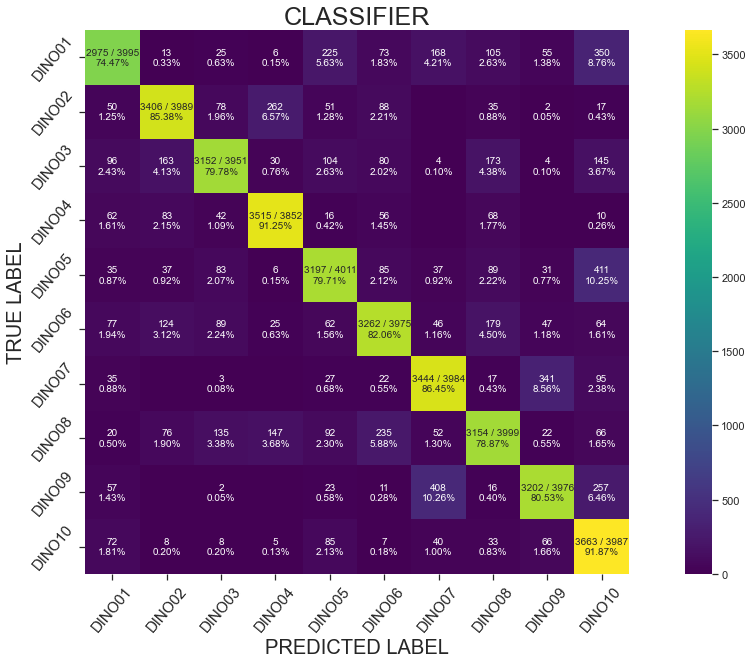

,PRECISION,RECALL,F1-SCORE,SUPPORT
0,0.86,0.74,0.80,3995
1,0.87,0.85,0.86,3989
2,0.87,0.80,0.83,3951
3,0.88,0.91,0.90,3852
4,0.82,0.80,0.81,4011
5,0.83,0.82,0.83,3975
6,0.82,0.86,0.84,3984
7,0.82,0.79,0.80,3999
8,0.85,0.81,0.83,3976
ACCURACY,-,-,0.83,39719


In [5]:
visualize_c_matrix(y_multi,
                   preds_multi,
                   title='',
                   categories=['Dino01', 'Dino02', 'Dino03', 'Dino04', 'Dino05',
                               'Dino06', 'Dino07', 'Dino08', 'Dino09', 'Dino10'], 
                   rotate=True, 
                   cmap='viridis',
                   cbar=True,
                   metrics=True,
                   save=False);

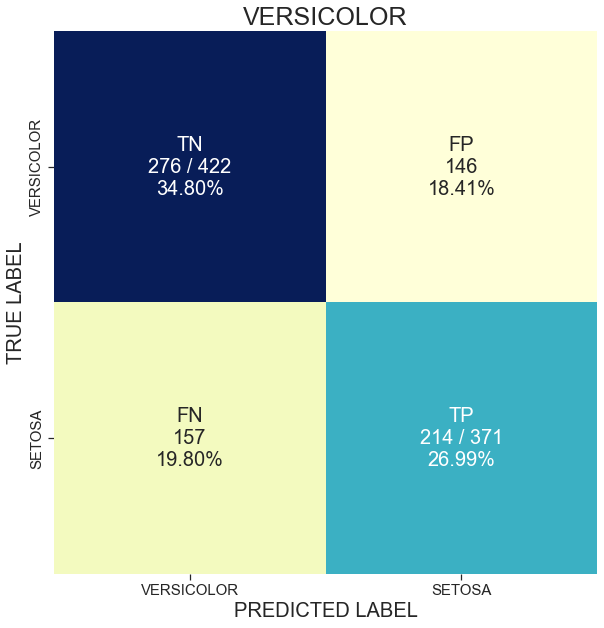

,VERSICOLOR
Accuracy: (TP + TN) / TOTAL,0.6179066835
Precision: TP / (TP + FP),0.5944444444
Recall: TP / (TP + FN),0.5768194070
"F1: harmonic mean (accuracy, recall)",0.5854993160
ROC AUC,0.6154239215


In [6]:
visualize_c_matrix(y2_test,
                   preds2,
                   title='VERSICOLOR',
                   categories=['Versicolor', 'Setosa'],
                   rotate=False,
                   cmap='YlGnBu',
                   cbar=False,
                   metrics=True);